In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
#from tensorflow import keras
#import tensorflow.compat
#import keras
import cv2
import numpy as np
import os
import zipfile
from matplotlib import image

files=zipfile.ZipFile('cats_and_dogs_small.zip','r')
files.extractall('')

x_dog=[]
x_cat=[]


# Filtrado de datos en gatos y perros

In [ ]:
from PIL import Image
x_size=150
y_size=150

for name in files.namelist():
    if '/dogs/' in name and '.jpg' in name:
        a=cv2.imread(name)
        a=cv2.resize(a,(x_size,y_size)) # Dimensión de la imagen
        img = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        #img2=img.resize(200,200) # Mobilenet (224,224,3)
        x_dog.append(img)
        
    elif '/cats/' in name and '.jpg' in name:
        a=cv2.imread(name)
        a=cv2.resize(a,(x_size,y_size)) # Dimensión de la imagen
        img = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        x_cat.append(img)
print(len(x_dog),len(x_cat))
x_dog=np.stack(x_dog,axis=0)
x_cat=np.stack(x_cat,axis=0)

# Normalización de datos

In [ ]:

print(type(x_dog),x_dog.shape)
print(type(x_cat),x_cat.shape)
x_dog=x_dog.astype('float32')
x,y,z,w=x_dog.shape
y_dog=np.zeros((x,1),dtype=int)
x_cat=x_cat.astype('float32')
x,y,z,w=x_cat.shape
y_cat=np.ones((x,1),dtype=int)
#x_dog=(x_dog/127.5)-1#x_dog/=255
#x_cat=(x_cat/127.5)-1#x_cat/=255
## Conjunto combinado de perros y gatos
x_comb=np.vstack((x_dog,x_cat))
y_comb=np.vstack((y_dog,y_cat))
print(x_comb.ndim,x_comb.shape)
print(y_dog)

In [ ]:
#import keras
### ONE HOT
from tensorflow.keras.utils import to_categorical
y_dog_oh=to_categorical(y_dog,y_dog.max()+2)
y_cat_oh=to_categorical(y_cat,y_cat.max()+1)
print(y_comb[3455])
y_comb_oh=to_categorical(y_comb,y_comb.max()+1)
print(y_comb_oh[3455])
print(type(y_comb_oh),y_comb_oh.shape)
print(y_cat_oh.shape)
print(y_dog_oh.shape)
print(y_dog_oh)
#print(y_cat_oh)

In [ ]:
xx,yy,ww,zz=x_cat.shape
x_train=np.vstack((x_cat[:int(xx*0.6),:,:,:],x_dog[:int(xx*0.6),:,:,:]))
y_train=np.vstack((y_cat_oh[:int(xx*0.6),:],y_dog_oh[:int(xx*0.6),:]))
x_val=np.vstack((x_cat[int(xx*0.6):int(xx*0.8),:,:,:],x_dog[int(xx*0.6):int(xx*0.8),:,:,:]))
y_val=np.vstack((y_cat_oh[int(xx*0.6):int(xx*0.8),:],y_dog_oh[int(xx*0.6):int(xx*0.8),:]))
x_test=np.vstack((x_cat[int(xx*0.8):,:,:,:],x_dog[int(xx*0.8):,:,:,:]))
y_test=np.vstack((y_cat_oh[int(xx*0.8):,:],y_dog_oh[int(xx*0.8):,:]))

print(x_test.min())

# EfficientNet B0

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.efficientnet.EfficientNetB0 import EfficientNetB0
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import h5py
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint =  ModelCheckpoint('resnet50.h', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)    

x_train_res=tf.keras.applications.efficientnet.preprocess_input(np.copy(x_train))
x_val_res=tf.keras.applications.efficientnet.preprocess_input(np.copy(x_val))
x_test_res=tf.keras.applications.efficientnet.preprocess_input(np.copy(x_test))

model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(x_size,y_size,3),weights='imagenet',include_top=False) ## Colocar otro top
#model.summary()
sal=model.output
sal=Flatten()(sal)
sal=Dense(502,activation='relu')(sal)
sal=Dropout(0.26)(sal)
sal = Dense(256, activation='selu')(sal)
sal=Dense(100,activation='selu')(sal)
sal=Dense(50,activation='relu')(sal)
sal = Dense(2, activation='softmax')(sal)
#Se unen la CNN y el top
efnetb0_custom=Model(inputs=model.input, outputs=sal)
efnetb0_custom.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])
history=efnetb0_custom.fit(x_train_res,y_train,batch_size=64,epochs=10, validation_data=(x_val_res,y_val),callbacks=[lr_reduce,earlystopper,checkpoint])

In [ ]:
pred=efnetb0_custom.predict(x_test_res)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento','Validación'])
plt.title('Pérdida de entrenamiento y validación')
plt.grid()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

In [ ]:
## Salvar el modelo
efnetb0_custom.save('efnetb0.h5')



# Primer prueba de imagen 
**Correr desde aqui**

La imagen a probar será una imagen obtenida de internet que contiene 2 perros y 2 gatos

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
pygs=cv2.imread('muchos perros y gatos.jpg')
#pygs=cv2.resize(pygs,(x_size,y_size)) # Dimensión de la imagen
pygs = cv2.cvtColor(pygs, cv2.COLOR_BGR2RGB)

(400, 800, 3)


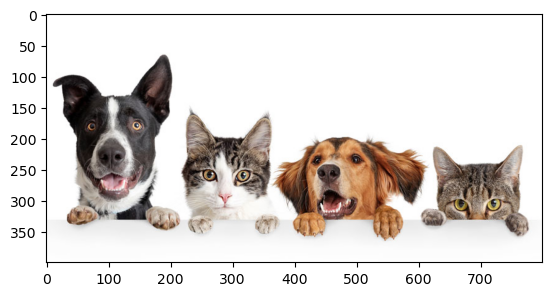

In [2]:
#cv2.rectangle(pygs,(0,150),(340,240),(255,0,0),4) #Prueba de rectangulo
plt.imshow(pygs)
print(pygs.shape)

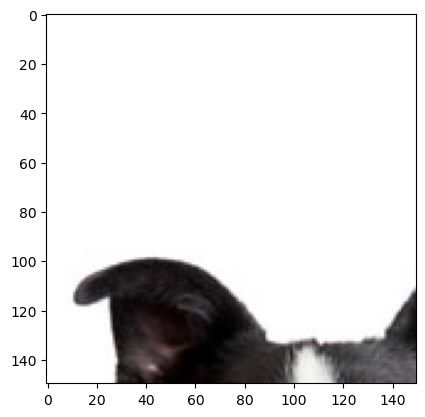

In [3]:
#Uso de Crop en la imagen
im1=pygs[0:150,0:150]
plt.imshow(im1)

In [4]:
pygs_segmentos=[]
ren,col,dim=pygs.shape
print(ren,col,dim)
x_size=150
y_size=150
coord_segx=[]
coord_segy=[]
cord_mat=np.arange(7*16)
cord_mat=np.reshape(cord_mat,(7,16))
for c in range(7): #(int(col/y_size)):
    for r in range(16): #(int(ren/x_size)):
        pygs_segmentos.append(pygs[c*40:(c*40)+150,r*40:(r*40)+150])
        coord_segx.append(r*40)
        coord_segy.append(c*40) # se le debe sumar x_shape y y_shape para el otro punto
        
pygs_segmentos=np.stack(pygs_segmentos,axis=0)
print(pygs_segmentos.shape)


400 800 3
(112, 150, 150, 3)


# Llamando al modelo

In [5]:
import tensorflow as tf
import h5py
from keras.models import Model, load_model
efnb0=tf.keras.models.load_model('efnetb0.h5')

# Realizando la predicción de los segmentos

In [6]:
# perro 1 0   gato 0 1 
prob_pygs=efnb0.predict(pygs_segmentos)
print(prob_pygs.shape)

4/4 [==============================] - 2s 173ms/step
(112, 2)


In [7]:
print(prob_pygs[0,:]) # Softmax falla probar con otra funcion de activación


[0.10102677 0.8989732 ]


In [8]:
"""
print(perro)
print(prob_pygs[:,0].max())
plt.imshow(pygs_segmentos[111,:,:,:])
print(coord_segx[86],coord_segy[86])
"""

'\nprint(perro)\nprint(prob_pygs[:,0].max())\nplt.imshow(pygs_segmentos[111,:,:,:])\nprint(coord_segx[86],coord_segy[86])\n'

# Metodo #1 
Consiste en obtener los valores máximos de las imagenes segmentadas y despues compararlas con sus vecinos, para realizar un promedio o una media ponderada para dar una probabilidad y encuadrar los valores del reconocimiento

## Prueba 1 con únicamente los valores máximos

In [9]:
sensibilidad=0.992
perro=np.where(prob_pygs[:,0]>=sensibilidad)
gato=np.where(prob_pygs[:,1]>=sensibilidad)
perro=list(perro[0])
gato=list(gato[0])
print('valores >=0.98 para perro:',perro)
print('valores >=0.98 para gato:',gato)
print(cord_mat)
#plt.imshow(pygs_segmentos[111,:,:,:])
print('gatos:',len(gato),'perros:',len(perro))

valores >=0.98 para perro: [34, 49, 73, 89, 91]
valores >=0.98 para gato: [39, 55, 70, 71, 84, 85, 95]
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47]
 [ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]]
gatos: 7 perros: 5


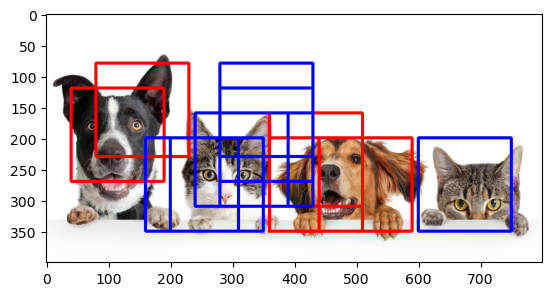

In [10]:
im_prueba1=cv2.imread('muchos perros y gatos.jpg')
im_prueba1=cv2.cvtColor(im_prueba1, cv2.COLOR_BGR2RGB)
#plt.imshow(im_prueba1)
for aa in perro:
    cv2.rectangle(im_prueba1,(coord_segx[aa],coord_segy[aa]),(coord_segx[aa]+150,coord_segy[aa]+150),(255,0,0),4)
    #print(coord_segx[aa],coord_segy[aa])
for bb in gato:
    cv2.rectangle(im_prueba1,(coord_segx[bb],coord_segy[bb]),(coord_segx[bb]+150,coord_segy[bb]+150),(0,0,255),4)
plt.imshow(im_prueba1)

## Para perros:

In [11]:
prom_prob_p=[]
exepcion_p=0.5
#"""
for p in range(len(perro)):
    xx,yy=np.where(cord_mat==perro[p])
    #print(perro[p])
    xx=int(xx)
    yy=int(yy)
    try:
        p1=prob_pygs[p,0]
    except:
        p1=exepcion_p
    try:
        p2=prob_pygs[cord_mat[xx-1][yy],0] #arriba
    except:
        p2=exepcion_p
    try:
        p3=prob_pygs[cord_mat[xx-1][yy+1],0] #arr-der
    except:
        p3=exepcion_p
    try:
        p4=prob_pygs[cord_mat[xx][yy+1],0] #derecha
    except:
        p4=exepcion_p
    try:
        p5=prob_pygs[cord_mat[xx+1][yy+1],0] #abajo-der 
    except:
        p5=exepcion_p
    try:
        p6=prob_pygs[cord_mat[xx+1][yy],0] # abajo
    except:
        p6=exepcion_p
    try:
        p7=prob_pygs[cord_mat[xx+1][yy-1],0] #ab-izquierda
    except:
        p7=exepcion_p
    try:
        p8=prob_pygs[cord_mat[xx][yy-1],0] # izq
    except:
        p8=exepcion_p
    try:
        p9=prob_pygs[cord_mat[xx-1][yy-1],0] #izq-arr
    except:
        p9=exepcion_p
    prom_prob_p.append(np.mean([p1,p2,p3,p4,p5,p6,p7,p8,p9]))
#"""
print(prom_prob_p)

[0.53328365, 0.8641559, 0.641704, 0.8584508, 0.69553924]


## Para gatos:

In [12]:
prom_prob_g=[]
exepcion_g=1
#"""
for p in range(len(gato)):
    xx,yy=np.where(cord_mat==gato[p])
    #print(perro[p])
    xx=int(xx)
    yy=int(yy)
    try:
        p1=prob_pygs[p,1]
    except:
        p1=exepcion_g
    try:
        p2=prob_pygs[cord_mat[xx-1][yy],1] #arriba
    except:
        p2=exepcion_g
    try:
        p3=prob_pygs[cord_mat[xx-1][yy+1],1] #arr-der
    except:
        p3=exepcion_g
    try:
        p4=prob_pygs[cord_mat[xx][yy+1],1] #derecha
    except:
        p4=exepcion_g
    try:
        p5=prob_pygs[cord_mat[xx+1][yy+1],1] #abajo-der 
    except:
        p5=exepcion_g
    try:
        p6=prob_pygs[cord_mat[xx+1][yy],1] # abajo
    except:
        p6=exepcion_g
    try:
        p7=prob_pygs[cord_mat[xx+1][yy-1],1] #ab-izquierda
    except:
        p7=exepcion_g
    try:
        p8=prob_pygs[cord_mat[xx][yy-1],1] # izq
    except:
        p8=exepcion_g
    try:
        p9=prob_pygs[cord_mat[xx-1][yy-1],1] #izq-arr
    except:
        p9=exepcion_g
    prom_prob_g.append(np.mean([p1,p2,p3,p4,p5,p6,p7,p8,p9]))
#"""
print(prom_prob_g)

[0.8580277, 0.7468798, 0.8975928, 0.60555464, 0.81496173, 0.9143136, 0.8828695813814799]


# Parte 2: Uso de filtro de media
se realiza un filtro de media como se muestra a continuación

$$P_{media}(x)=\frac{P(x)_{max}+P(x)_{min}}{2}$$

Para posteriormente realizar una categorización

$$f(P(x)_n)=\left\{ \begin{array}{lcc}
             1 &   si  & P(x)_{n} \geq P_{media}(x) \\
             \\ 0 &  si & P(x)_{n} < P_{media}(x) \\
             \end{array}
   \right.$$

In [13]:
m_g=(max(prom_prob_g)+min(prom_prob_g))/2
m_p=(max(prom_prob_p)+min(prom_prob_p))/2
print('media prob gato:',m_g, 'media probabilidad perro:',m_p)

media prob gato: 0.75993412733078 media probabilidad perro: 0.6987197399139404


### Cantidad de perros y gatos


280 80
240 160
160 200
200 200
600 200
sensibilidad: 0.992
media prob gato: 0.75993412733078 media probabilidad perro: 0.6987197399139404
cantidad de gatos: 5 cantidad de perros: 2
excepción gato: 1 excepcion perros 0.5


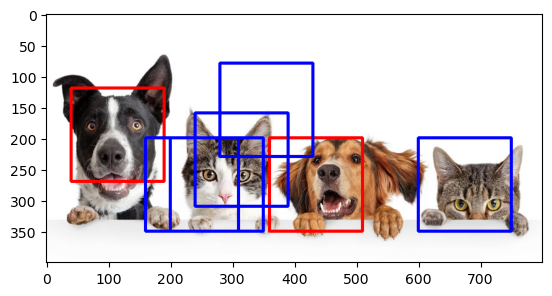

In [14]:
#para perros
p_ac_p=[]
p_ac_g=[]
im_prueba2=cv2.imread('muchos perros y gatos.jpg')
im_prueba2=cv2.cvtColor(im_prueba2, cv2.COLOR_BGR2RGB)
for uu in range(len(prom_prob_p)):
    if prom_prob_p[uu]>=m_p:
        cv2.rectangle(im_prueba2,(coord_segx[perro[uu]],coord_segy[perro[uu]]),(coord_segx[perro[uu]]+150,coord_segy[perro[uu]]+150),(255,0,0),4)
        p_ac_p.append(prom_prob_p[uu])
        
for ii in range(len(prom_prob_g)):
    if prom_prob_g[ii]>=m_g:
        cv2.rectangle(im_prueba2,(coord_segx[gato[ii]],coord_segy[gato[ii]]),(coord_segx[gato[ii]]+150,coord_segy[gato[ii]]+150),(0,0,255),4)
        print(coord_segx[gato[ii]],coord_segy[gato[ii]])
        p_ac_g.append(prom_prob_g[ii])
print('sensibilidad:',sensibilidad)
print('media prob gato:',m_g, 'media probabilidad perro:',m_p)
print('cantidad de gatos:',len(p_ac_g),'cantidad de perros:',len(p_ac_p))
print('excepción gato:',exepcion_g,'excepcion perros',exepcion_p)
plt.imshow(im_prueba2)